# Machine Learning to detect pants

In this notebook, we will be training our pants model to use on predicitions and therefore, be able to detect the required pants

### Library Imports

In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib
import itertools

%matplotlib inline
from IPython.display import Image
from PIL import Image as ImagePL
from scipy.ndimage import zoom


# Libraries for TensorFlow
from tensorflow.keras import preprocessing
from tensorflow.keras.preprocessing import image
from tensorflow.keras import models, layers
from tensorflow.keras.models import clone_model
from tensorflow.keras.applications import resnet50
from tensorflow.keras import backend as K

from tensorflow.keras.applications.resnet50 import preprocess_input

import tensorflow as tf

from sklearn.metrics import precision_score, recall_score, confusion_matrix, classification_report, accuracy_score, f1_score
from sklearn.utils import class_weight


### Load data

Dataset extracted from: https://www.kaggle.com/agrigorev/clothing-dataset-full

References from 

https://www.kaggle.com/pintu161/transfer-learning-in-pytorch-using-resnet18/notebook

https://www.kaggle.com/marissafernandes/clothes-image-classifier/notebook

https://www.kaggle.com/viratkothari/image-classification-transfer-learning-resnet50

In [2]:
originalCSV = pd.read_csv('Data/images.csv')
originalCSV.head()

,image,sender_id,label,kids
0,4285fab0-751a-4b74-8e9b-43af05deee22,124,Not sure,False
1,ea7b6656-3f84-4eb3-9099-23e623fc1018,148,T-Shirt,False
2,00627a3f-0477-401c-95eb-92642cbe078d,94,Not sure,False
3,ea2ffd4d-9b25-4ca8-9dc2-bd27f1cc59fa,43,T-Shirt,False
4,3b86d877-2b9e-4c8b-a6a2-1d87513309d0,189,Shoes,False


In [3]:
def imageCleaning(path):
    extensions = []
    bad_list = []
    for filee in os.listdir(path):
        file_path = os.path.join(path, filee)
        print('** Path: {}  **'.format(file_path), end="\r", flush=True)
        try:
            im = ImagePL.open(file_path)
            rgb_im = im.convert('RGB')
            if filee.split('.')[1] not in extensions:
                extensions.append(filee.split('.')[1])
        except:
            print("Error with " + file_path)
            bad_list.append(file_path)

#imageCleaning('Data\images_compressed')

In [4]:
typeOfData = originalCSV["label"].value_counts()
typeOfData

T-Shirt       1011
Longsleeve     699
Pants          692
Shoes          431
Shirt          378
Dress          357
Outwear        312
Shorts         308
Not sure       228
Hat            171
Skirt          155
Polo           120
Undershirt     118
Blazer         109
Hoodie         100
Body            69
Other           67
Top             43
Blouse          23
Skip            12
Name: label, dtype: int64

## Data cleaning

Since most of the data has been categorized, and we are mostly interested on some of the labels, and not all, to simplify and improve the training process, we are going to remove some of the categories. And transform them into a single type. We will transform those labels into, Top, Shorts, Pants, and remove some

The label Top will contain:
T-Shirt
LongSleeve
Shirt

The label Bottom will contain:
Pants

The other Shorts will contain:
Shorts

The removed ones will be:
Skirt
Dress
OutWear
Hat
Blazer
Hoodie
Skip
Blouse
Top
Polo
Undershirt.

Also, all data regarding kids will be removed too

In [5]:
imagesPath = 'Data/images_compressed'
dataCSV = originalCSV.copy()
dataCSV['image'] = imagesPath + '/' + originalCSV['image'] +'.jpg' #We adjust the data so that it is well defined
dataCSV.dropna()

dataCSV.loc[dataCSV['label'] == 'T-Shirt','label'] = 'Top'
dataCSV.loc[dataCSV['label'] == 'LongSleeve','label'] = 'Top'
dataCSV.loc[dataCSV['label'] == 'Shirt','label'] = 'Top'

dataCSV.loc[dataCSV['label'] == 'Pants','label'] = 'Bottom_Long'

dataCSV.loc[dataCSV['label'] == 'Shorts','label'] = 'Bottom_Short'
#kidsRemoved = dataCSV.loc[dataCSV["kids"] == "False"]

newColumns = ['Top','Bottom_Long', 'Bottom_Short']
finalData = dataCSV.loc[dataCSV["label"].str.contains("Top|Bottom_Long|Bottom_Short")]
data_df = finalData[['image', 'label']]

Now we can check our new data

In [6]:
typeOfData = data_df["label"].value_counts()
data_df.head()

,image,label
1,Data/images_compressed/ea7b6656-3f84-4eb3-9099...,Top
3,Data/images_compressed/ea2ffd4d-9b25-4ca8-9dc2...,Top
5,Data/images_compressed/5d3a1404-697f-479f-9090...,Bottom_Short
6,Data/images_compressed/b0c03127-9dfb-4573-8934...,Top
7,Data/images_compressed/4c8f245e-a039-46fd-a6b9...,Top


## Loading Data

It is required to prepare the data to be used on our model. To do so, we will transform the existing paths of images, to the specific image

#### I need to take a look at asynchronous file loading 

In [7]:
VALIDATION_SPLIT = 0.2
BATCH_SIZE = 32
WIDTH = 224
HEIGHT = 224
EPOCHS = 20

### Data set generators

In [8]:
def createTrainSetAndValidationSet(data):
    generator = image.ImageDataGenerator(
        rescale=1./255,
        validation_split=VALIDATION_SPLIT
    )
    train_set = generator.flow_from_dataframe(
        dataframe=data,
        x_col="image",
        y_col="label",
        target_size=(WIDTH, HEIGHT),
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        subset='training',
        shuffle=True
    )
    val_set = generator.flow_from_dataframe(
        dataframe=data,
        x_col="image",
        y_col="label",
        target_size=(WIDTH, HEIGHT),
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        subset='validation',
        shuffle=False
    )
    num_classes = len(train_set.class_indices)
    print("Total classes:", num_classes)
    return train_set, val_set, num_classes

### Checkpoint generator

In [9]:
def checkPointCreation(checkpoint_path):
    checkpoint_dir = os.path.dirname(checkpoint_path)

    # Create a callback that saves the model's weights
    cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)
    return cp_callback

### Weights generator

In [10]:
def generateWeights(labels):
    class_weights = class_weight.compute_class_weight('balanced',classes = np.unique(labels),y=labels)
    leng = max(labels)
    class_weight_dict = {i : class_weights[i] for i in range(leng+1)}
    print(class_weight_dict)
    return class_weight_dict

### Model generator

It would be interesting to use a pretrained model so that the training process is slowed down, and potentially, we will get better results. To avoid retraining it, we can use a common model like resNet. Therefore we can make use of pythorch pretrained models. We will split the data into the test and train data set so that we can use it for our pretrained model

https://keras.io/api/layers/

In [11]:
def generateModel(classesAmount):
    input_layer = layers.Input(shape=(WIDTH,HEIGHT,3)) #We set the input layer to the data format we desire

    resNet=resnet50.ResNet50(weights='imagenet', input_tensor=input_layer,include_top=False) #We get the resnet model
    last_layer=resNet.output #We take output layers of resnet
    flatten=layers.Flatten()(last_layer) # Add flatten layer: we are extending Neural Network by adding flattn layer
    
    # Add dense layer to the final output layer
    output_layer = layers.Dense(classesAmount,activation='softmax')(flatten)

    # Creating model with input and output layer
    model=models.Model(inputs=input_layer,outputs=output_layer)
    model.summary()

    #for layer in model.layers[:-1]: #Freezing lower layers (in this case only lower layer)
    #    layer.trainable=False
    model.summary()
    return clone_model(model)

Once the model is prepared we can train it

### Unbalanced Model

We will first try with an unbalanced weighting on the data

In [12]:
train_set, val_set, num_classes = createTrainSetAndValidationSet(data_df)
cp_callback_unbalanced = checkPointCreation("checkPoints/modelTraining_unbalanced/cp.ckpt")

Found 1946 validated image filenames belonging to 3 classes.
Found 486 validated image filenames belonging to 3 classes.
Total classes: 3


In [13]:
unbalancedModel = generateModel(num_classes)
unbalancedModel.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

                                                                                                  
 conv2_block3_1_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block3_2_conv (Conv2D)   (None, 56, 56, 64)   36928       ['conv2_block3_1_relu[0][0]']    
                                                                                                  
 conv2_block3_2_bn (BatchNormal  (None, 56, 56, 64)  256         ['conv2_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block3_2_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv3_block3_1_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block3_2_conv (Conv2D)   (None, 28, 28, 128)  147584      ['conv3_block3_1_relu[0][0]']    
                                                                                                  
 conv3_block3_2_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block3_2_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv4_block2_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block2_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block2_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block2_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block2_1_relu[0][0]']    
                                                                                                  
 conv4_block2_2_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block2_2_conv[0][0]']    
 ization) 

 conv4_block5_1_conv (Conv2D)   (None, 14, 14, 256)  262400      ['conv4_block4_out[0][0]']       
                                                                                                  
 conv4_block5_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block5_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block5_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block5_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block5_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block5_1_relu[0][0]']    
                                                                                                  
 conv4_blo

                                                                  'conv5_block1_3_bn[0][0]']      
                                                                                                  
 conv5_block1_out (Activation)  (None, 7, 7, 2048)   0           ['conv5_block1_add[0][0]']       
                                                                                                  
 conv5_block2_1_conv (Conv2D)   (None, 7, 7, 512)    1049088     ['conv5_block1_out[0][0]']       
                                                                                                  
 conv5_block2_1_bn (BatchNormal  (None, 7, 7, 512)   2048        ['conv5_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block2_1_relu (Activatio  (None, 7, 7, 512)   0           ['conv5_block2_1_bn[0][0]']      
 n)       

 pool1_pool (MaxPooling2D)      (None, 56, 56, 64)   0           ['pool1_pad[0][0]']              
                                                                                                  
 conv2_block1_1_conv (Conv2D)   (None, 56, 56, 64)   4160        ['pool1_pool[0][0]']             
                                                                                                  
 conv2_block1_1_bn (BatchNormal  (None, 56, 56, 64)  256         ['conv2_block1_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block1_1_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block1_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_blo

 conv2_block3_out (Activation)  (None, 56, 56, 256)  0           ['conv2_block3_add[0][0]']       
                                                                                                  
 conv3_block1_1_conv (Conv2D)   (None, 28, 28, 128)  32896       ['conv2_block3_out[0][0]']       
                                                                                                  
 conv3_block1_1_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block1_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block1_1_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block1_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_blo

 conv3_block3_out (Activation)  (None, 28, 28, 512)  0           ['conv3_block3_add[0][0]']       
                                                                                                  
 conv3_block4_1_conv (Conv2D)   (None, 28, 28, 128)  65664       ['conv3_block3_out[0][0]']       
                                                                                                  
 conv3_block4_1_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block4_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block4_1_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block4_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_blo

                                                                                                  
 conv4_block2_add (Add)         (None, 14, 14, 1024  0           ['conv4_block1_out[0][0]',       
                                )                                 'conv4_block2_3_bn[0][0]']      
                                                                                                  
 conv4_block2_out (Activation)  (None, 14, 14, 1024  0           ['conv4_block2_add[0][0]']       
                                )                                                                 
                                                                                                  
 conv4_block3_1_conv (Conv2D)   (None, 14, 14, 256)  262400      ['conv4_block2_out[0][0]']       
                                                                                                  
 conv4_block3_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block3_1_conv[0][0]']    
 ization) 

 ization)                       )                                                                 
                                                                                                  
 conv4_block5_add (Add)         (None, 14, 14, 1024  0           ['conv4_block4_out[0][0]',       
                                )                                 'conv4_block5_3_bn[0][0]']      
                                                                                                  
 conv4_block5_out (Activation)  (None, 14, 14, 1024  0           ['conv4_block5_add[0][0]']       
                                )                                                                 
                                                                                                  
 conv4_block6_1_conv (Conv2D)   (None, 14, 14, 256)  262400      ['conv4_block5_out[0][0]']       
                                                                                                  
 conv4_blo

 conv5_block2_3_conv (Conv2D)   (None, 7, 7, 2048)   1050624     ['conv5_block2_2_relu[0][0]']    
                                                                                                  
 conv5_block2_3_bn (BatchNormal  (None, 7, 7, 2048)  8192        ['conv5_block2_3_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block2_add (Add)         (None, 7, 7, 2048)   0           ['conv5_block1_out[0][0]',       
                                                                  'conv5_block2_3_bn[0][0]']      
                                                                                                  
 conv5_block2_out (Activation)  (None, 7, 7, 2048)   0           ['conv5_block2_add[0][0]']       
                                                                                                  
 conv5_blo

KeyboardInterrupt: 

In [ ]:
unbalancedModel.fit(train_set,epochs=EPOCHS,verbose=True,validation_data=val_set, callbacks=[cp_callback_unbalanced])

In [ ]:
unbalancedModel.save('saved_model/pantsModel_unbalanced')

### Balanced Model

We will also train a blanaced Model, having some balanced weights to use

In [ ]:
train_set, val_set, num_classes = createTrainSetAndValidationSet(data_df)
cp_callback_balanced = checkPointCreation("checkPoints/modelTraining_balanced/cp.ckpt")
class_weight_dict = generateWeights(train_set.labels)

In [ ]:
balancedModel = generateModel(num_classes)
balancedModel.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])

In [ ]:
balancedModel.fit(train_set,epochs=EPOCHS,verbose=True,validation_data=val_set, callbacks=[cp_callback_balanced], class_weight = class_weight_dict)

In [ ]:
balancedModel.save('saved_model/pantsModel_balanced')

## Observing results

In [14]:
"""
Function extracted from https://deeplizard.com/learn/video/km7pxKy4UHU to create a confusion matrix
"""
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

## Balanced Model

In [15]:
balancedModel = models.load_model('saved_model/pantsModel_balanced')
predictions = balancedModel.predict(train_set)
rounded_predictions = np.argmax(predictions, axis=-1)
balancedModel.evaluate(train_set)

61/61 [==============================] - 84s 1s/step - loss: 0.6327 - accuracy: 0.6835


[0.632738471031189, 0.6834532618522644]

Confusion matrix, without normalization
[[123 225 208]
 [ 35 115  77]
 [260 482 421]]


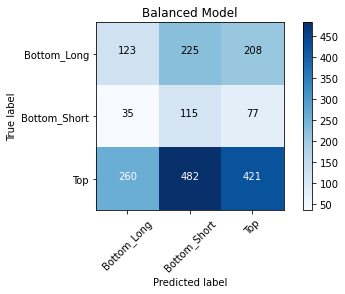

In [16]:
cm = confusion_matrix(y_true=train_set.labels, y_pred=rounded_predictions)
plot_confusion_matrix(cm=cm, classes=train_set.class_indices, title='Balanced Model')

## Unbalanced Model

In [17]:
unbalancedModel = models.load_model('saved_model/pantsModel_unbalanced')
predictions = unbalancedModel.predict(train_set)
rounded_predictions = np.argmax(predictions, axis=-1)
unbalancedModel.evaluate(train_set)

61/61 [==============================] - 85s 1s/step - loss: 0.2973 - accuracy: 0.8993


[0.297267347574234, 0.8992805480957031]

Confusion matrix, without normalization
[[149  29 378]
 [ 56  16 155]
 [360  49 754]]


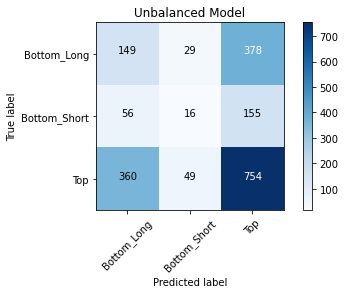

In [18]:
cm = confusion_matrix(y_true=train_set.labels, y_pred=rounded_predictions)
plot_confusion_matrix(cm=cm, classes=train_set.class_indices, title='Unbalanced Model')

# Training the model without modification

As seen on the previous models, the data has really bad results, let's try without modifying the data

In [19]:
imagesPath = 'Data/images_compressed'
newCSV = originalCSV.copy()
newCSV['image'] = imagesPath + '/' + originalCSV['image'] +'.jpg' #We adjust the data so that it is well defined
newCSV = newCSV[['image', 'label']]

In [20]:
train_set, val_set, num_classes = createTrainSetAndValidationSet(newCSV)

C:\Users\pauso\anaconda3\envs\TFG_Project\lib\site-packages\keras_preprocessing\image\dataframe_iterator.py:279: UserWarning: Found 5 invalid image filename(s) in x_col="image". These filename(s) will be ignored.
  warnings.warn(


Found 4319 validated image filenames belonging to 20 classes.
Found 1079 validated image filenames belonging to 20 classes.
Total classes: 20


C:\Users\pauso\anaconda3\envs\TFG_Project\lib\site-packages\keras_preprocessing\image\dataframe_iterator.py:279: UserWarning: Found 5 invalid image filename(s) in x_col="image". These filename(s) will be ignored.
  warnings.warn(


### Unbalanced

In [ ]:
train_set, val_set, num_classes = createTrainSetAndValidationSet(newCSV)
cp_callback_original_unbalanced= checkPointCreation("checkPoints/modelTraining_original_unbalanced/cp.ckpt")

In [ ]:
originalModel_unbalanced = generateModel(num_classes)
originalModel_unbalanced.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])

In [ ]:
originalModel_unbalanced.fit(train_set,epochs=EPOCHS,verbose=True,validation_data=val_set, callbacks=[cp_callback_original_unbalanced])

In [ ]:
originalModel_unbalanced.save('saved_model/pantsModel_original_unbalanced')

## Balanced

In [ ]:
train_set, val_set, num_classes = createTrainSetAndValidationSet(newCSV)
cp_callback_original_balanced= checkPointCreation("checkPoints/modelTraining_original_balanced/cp.ckpt")
class_weight_dict_org = generateWeights(train_set.labels)

In [ ]:
originalModel_balanced = generateModel(num_classes)
originalModel_balanced.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])

In [ ]:
originalModel_balanced.fit(train_set,epochs=EPOCHS,verbose=True,validation_data=val_set, callbacks=[cp_callback_original_balanced], class_weight = class_weight_dict_org)

In [ ]:
originalModel_balanced.save('saved_model/pantsModel_original_balanced')

## Visualizing original

## Balanced

In [21]:
originalModel_balanced = models.load_model('saved_model/pantsModel_original_balanced')
predictions = originalModel_balanced.predict(train_set_org)
rounded_predictions = np.argmax(predictions, axis=-1)
originalModel_balanced.evaluate(train_set_org)

OSError: No file or directory found at saved_model/pantsModel_original_balanced

In [ ]:
cm = confusion_matrix(y_true=train_set_org.labels, y_pred=rounded_predictions)
plot_confusion_matrix(cm=cm, classes=train_set_org.class_indices, title='Original Model Balanced')

## Unbalanced

In [22]:
originalModel_unbalanced = models.load_model('saved_model/pantsModel_original_unbalanced')
print("Model loaded")
predictions = originalModel_unbalanced.predict(train_set)
rounded_predictions = np.argmax(predictions, axis=-1)
originalModel_unbalanced.evaluate(train_set_org)

NameError: name 'train_set_org' is not defined

In [ ]:
cm = confusion_matrix(y_true=train_set.labels, y_pred=rounded_predictions)
plot_confusion_matrix(cm=cm, classes=train_set.class_indices, title='Original Model UnBalanced')

# First conclusions

It is clear that by just using transfer learning as show before, the results are bad, therefore i shall find a better way. Possible options are using a differential learning rate.

Instead of unfreezing specific layers, it’s probably a better idea to use a differential learning rate, where the learning rate is determined on a per-layer basis. The bottom layers will then have a very low learning rate, as these generalise quite well, responding principally to edges, blobs and other trivial geometries, whereas the layers responding to more complex features will have a larger learning rate. In the past, the 2:4:6 rule (negative powers of 10) has worked quite well for me — using a learning rate of 10^-6 for the bottommost few layers, 10^-4 for the other transfer layers and 10^-2 for any additional layers we added. I have also heard others using 2:3:4:5:6 or 2:3:4 with different architectures. For ResNets and their derivatives, I have always felt more comfortable with 2:4:6 than 2:3:4, but I have absolutely no empirical evidence to back this up with. (https://medium.com/starschema-blog/transfer-learning-the-dos-and-donts-165729d66625)

Also, redoing it from scratch,

When transferring to a task with a relatively large data set, you might want to train the network from scratch (which would make it not transfer learning at all). At the same time — given that such a network would be initialised with random values, you have nothing to lose by using the pretrained weights! Unfreeze the entire network, remove the output layer and replace it with one matching the number of destination task classes, and fine-tune the whole network.

Same reference

In [2]:
modelTest = models.load_model('saved_model/pantsModel_unbalanced')
img=image.load_img(r'Data\images_compressed\1c899f7b-08a9-488e-80b5-3636d7f633d4.jpg',target_size=(224,224))
img_tensor = preprocessing.image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)

In [4]:
def gradCAM(orig, model, intensity=0.5, res=224):
  img = image.load_img(orig, target_size=(224, 224))

  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  x = preprocess_input(x)

  preds = model.predict(x)
  #print(decode_predictions(preds)[0][0][1]) # prints the class of image

  with tf.GradientTape() as tape:
    last_conv_layer = model.get_layer('conv5_block3_3_conv')
    iterate = tf.keras.models.Model([model.inputs], [model.output, last_conv_layer.output])
    model_out, last_conv_layer = iterate(x)
    class_out = model_out[:, np.argmax(model_out[0])]
    grads = tape.gradient(class_out, last_conv_layer)
    pooled_grads = K.mean(grads, axis=(0, 1, 2))
    
  heatmap = tf.reduce_mean(tf.multiply(pooled_grads, last_conv_layer), axis=-1)
  heatmap = np.maximum(heatmap, 0)
  #heatmap /= np.max(heatmap)
  heatmap = heatmap.reshape((7, 7))

  img = cv2.imread(orig)

  heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

  heatmap = cv2.applyColorMap(np.uint8(255*heatmap), cv2.COLORMAP_JET)

  img = heatmap * intensity + img

  #cv2.imshow("img", cv2.resize(cv2.imread(orig), (res, res)))
  cv2.imshow("img", img)
    
  cv2.waitKey(0)
    
gradCAM(r'Data\images_compressed\1c899f7b-08a9-488e-80b5-3636d7f633d4.jpg', modelTest)